# Ground state calculations of the double well quantum dot

Given a basis set $\{\psi_{\alpha}\}_{\alpha = 1}^L$ of single particle functions that are eigenfunctions to the one-body Hamiltonian operator for the double well system, $h_{\text{DW}}$, i.e.,

\begin{align}
    h_{\text{DW}}\rvert\psi_{\alpha}\rangle = \epsilon_{\alpha}\rvert\psi_{\alpha}\rangle,
\end{align}

where $\epsilon_{\alpha}$ is the eigenenergy of the single particle function $\rvert\psi_{\alpha}\rangle$. The double well one-body operator (with a perturbation in the $x$-direction) is given by

\begin{align}
    h_{\text{DW}}
    &= -\frac{\hbar^2}{2m}\nabla^2 + \frac{1}{2}m\omega^2 r^2
        + \frac{1}{2}m\omega^2\left(
            \frac{1}{4}R^2 - R|x|
        \right) \\
    &= h_{\text{HO}} + \frac{1}{2}m\omega^2\left(
            \frac{1}{4}R^2 - R|x|
        \right),
\end{align}
where $h_{\text{HO}}$ is the one-body Hamiltonian for the harmonic oscillator. The one-body potentials are thus

\begin{gather}
    v_{\text{HO}} = \frac{1}{2}m\omega^2 r^2, \\
    v_{\text{DW}} = v_{\text{HO}} + \frac{1}{2}m\omega^2\left(
            \frac{1}{4}R^2 - R|x|
        \right).
\end{gather}

We can solve this directly by discretizing the space we are working in and constructing the full matrix $h_{\text{DW}}$ before diagonalizing.

## Solving the one-dimensional double well quantum dot directly

By limiting ourselves to one dimension we can set up the one-body Hamiltonian matrix directly and diagonalize it to find the eigenenergies, $\epsilon_{\alpha}$, and the corresponding eigenfunctions, $\rvert\psi_{\alpha}\rangle$.

In [53]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.sparse
import scipy.sparse.linalg
import time
import matplotlib.pyplot as plt
import scipy.special

from mpl_toolkits.mplot3d import Axes3D

from IPython.core.display import display

We restrict ourselves to equal masses and natural units, thus we set

\begin{align}
    \hbar = m = c = 1.
\end{align}

In [13]:
# Natural units
m = 1
hbar = 1

Below we set the frequency, $\omega$, and the radius of the double well, $R$.

In [21]:
omega = 1
radius = 2

Next, we set up the potentials.

In [28]:
# Note that r is one-dimensional
v_ho = lambda r, omega, m=m, hbar=hbar: 0.5*m*omega**2*r**2
v_dw = lambda r, omega, radius=radius, m=m, hbar=hbar: v_ho(r, omega, m=m, hbar=hbar) \
    + 0.5*m*omega**2*(0.25*radius**2 - radius*abs(r))

### Setting up the one-body Hamiltonian matrix

We use central finite differences for the kinetic term in $h_{\text{DW}}$.

\begin{align}
    \frac{\text{d}^2 u(x)}{\text{d} x^2}
    \approx \frac{u(x + \Delta x) - 2 u(x) + u(x - \Delta x)}{(\Delta x)^2}.
\end{align}

By letting the wavefunction $u(x)$ work on the one-dimensional one-body Hamiltonian we get

\begin{align}
    h_{\text{DW}}u(x) = -\frac{1}{2}\frac{\text{d}^2 u(x)}{\text{d} x^2} + v_{\text{DW}}u(x).
\end{align}

We now discretize the space into $i \in \{1, n\}$ points and insert the finite difference approximation. We label the wavefunction by $u(x_i) = u_i$.

\begin{align}
    h_{\text{DW}}u_{i}
    &= -\frac{1}{2} \frac{u_{i + 1} - 2 u_i + u_{i - 1}}{(\Delta x)^2}
        + v_{\text{DW}}u_i \\
    &= \left(\frac{1}{(\Delta x)^2} + v_{\text{DW}}\right) u_i
        - \frac{1}{2(\Delta x)^2}\left(u_{i + 1} + u_{i - 1}\right).
\end{align}

By treating $u$ as a vector with components $u_i$ we can construct a matrix from the one-body Hamiltonian.

\begin{align}
    h_{\text{DW}} u
    &=
    \begin{pmatrix}
        \frac{1}{(\Delta x)^2} + v_{\text{DW}} & -\frac{1}{2(\Delta x)^2} & 0 & 0 & \dots & 0 & 0 \\
        -\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2} + v_{\text{DW}} & -\frac{1}{2(\Delta x)^2}
        & 0 & \dots & 0 & 0 \\
        0 & -\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2} + v_{\text{DW}}
        & -\frac{1}{2(\Delta x)^2} & \dots & 0 & 0 \\
        \vdots & & \ddots & & \dots & & \\
        0 & 0 & 0 & 0 & \dots & -\frac{1}{2(\Delta x)^2}
        & \frac{1}{(\Delta x)^2} + v_{\text{DW}}
    \end{pmatrix}
    \begin{pmatrix}
        u_1 \\
        u_2 \\
        u_3 \\
        u_4 \\
        u_5 \\
        \vdots \\
        u_n
    \end{pmatrix}
\end{align}

Incidentally, the choice of $n$ decides how many eigenstates we can extract. This is the same as $L$ in the number of basis functions for our problem. Nyquist's theorem tells us that we must have at least, in practice even more, twice as many grid points $n$ to get the eigenstate $\psi_{n/2}$.

In [66]:
# The size of the spatial room we look at
grid_length = -10
# Number of points to discretize the grid in
num_points = 1000

In [67]:
x = np.linspace(-grid_length, grid_length, num_points)
delta_x = x[1] - x[0]

In [68]:
h_diag = 1.0/(delta_x**2) + v_dw(
    x[1:num_points - 1], omega=omega, radius=radius, m=m, hbar=hbar)
h_off_diag = 1.0/(2*delta_x**2)

h = scipy.sparse.diags([h_diag, h_off_diag, h_off_diag], offsets=[0, 1, -1])

print (h.toarray())

[[ 2535.32252022  1247.50125        0.         ...,     0.             0.
      0.        ]
 [ 1247.50125     2535.14294124  1247.50125    ...,     0.             0.
      0.        ]
 [    0.          1247.50125     2534.96376306 ...,     0.             0.
      0.        ]
 ..., 
 [    0.             0.             0.         ...,  2534.96376306
   1247.50125        0.        ]
 [    0.             0.             0.         ...,  1247.50125
   2535.14294124  1247.50125   ]
 [    0.             0.             0.         ...,     0.          1247.50125
   2535.32252022]]


In [69]:
t0 = time.time()
epsilon, psi = scipy.sparse.linalg.eigs(h, k=3, which="SM")
t1 = time.time()

print ("Time spent on solving the eigenvalue problem: {0:.3f} sec".format(t1 - t0))

Time spent on solving the eigenvalue problem: 0.360 sec


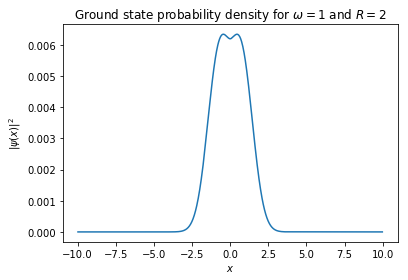

In [70]:
plt.plot(x[1:-1], np.abs(psi[:, 0])**2)
plt.title(
    (r"Ground state probability density for $\omega = ${0}"
    + " and $R = ${1}").format(omega, radius))
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.show()

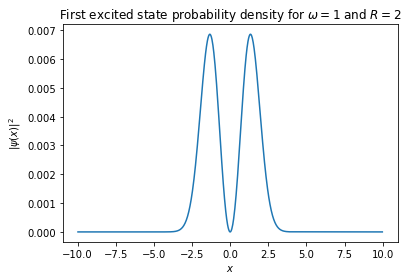

In [71]:
plt.plot(x[1:-1], np.abs(psi[:, 1])**2)
plt.title(
    (r"First excited state probability density for $\omega = ${0}"
    + " and $R = ${1}").format(omega, radius))
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.show()

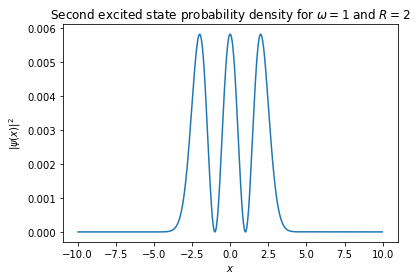

In [72]:
plt.plot(x[1:-1], np.abs(psi[:, 2])**2)
plt.title(
    (r"Second excited state probability density for $\omega = ${0}"
    + " and $R = ${1}").format(omega, radius))
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi(x)|^2$")
plt.show()

## Double well quantum dot in higher dimensions

The brute force approach shown above quickly grows in complexity by introducing more dimensions to the problem. This because the grid we are discretizing gets extra dimensions. By moving from one dimension where the problem of solving the differential equation is on the order of $\mathcal{O}(n^2)$ to two dimensionsions we get a complexity of $\mathcal{O}(n^4)$. To make it worse, when we include interactions we have to solve the integral

\begin{align}
    \langle\psi_{\alpha}\psi_{\beta}\lvert u \rvert\psi_{\gamma}\psi_{\delta}\rangle
    &= \int\text{d}\mathbf{r}_1\text{d}\mathbf{r}_2
    \psi_{\alpha}^*(\mathbf{r}_1)\psi_{\beta}^*(\mathbf{r}_2)
    u(\mathbf{r}_1, \mathbf{r}_2)
    \psi_{\gamma}(\mathbf{r}_1)\psi_{\delta}(\mathbf{r}_2),
\end{align}

where the Coulomb interaction is given by (in natural units)

\begin{align}
    u(\mathbf{r}_1, \mathbf{r}_2)
    &= \frac{1}{|\mathbf{r}_1 - \mathbf{r}_2|}.
\end{align}

This integral is $\mathcal{O}(n^4)$ hard. As we have to do this for the matrix $u \in \mathbb{R}^{n \times n \times n \times n}$. This results in $\mathcal{O}(n^8)$ operations.

### Change of basis

To avoid calculating the integral we expand the double well eigenstates as a linear combination of known eigenstates in a different basis state. Mathematically expressed as

\begin{align}
    \lvert\psi_{\alpha}\rangle
    &= \sum_{p = 1}^M \rvert\phi_p\rangle\langle \phi_p\lvert \psi_{\alpha}\rangle \\
    &= \sum_{p = 1}^M c_{p\alpha} \lvert\phi_p\rangle,
\end{align}

where $\{\phi_p\}_{p = 1}^M$ is a known set of eigenstates, e.g., eigenstates to the harmonic oscillator, and $c_{p\alpha}$ are coefficients. Strictly speaking the equality when we change basis should be an approximation as we are not guaranteed that the set of $M$ basis functions $\{\phi_p\}$ can exactly approximate the basis functions $\{\psi_{\alpha}\}$. This lets us rewrite the one-body double well eigenequation as

\begin{gather}
    h_{\text{DW}}\lvert\psi_{\alpha}\rangle = \epsilon_{\alpha}\lvert\psi_{\alpha}\rangle \\
    \implies
    h_{\text{DW}}\sum_{p = 1}^M c_{p\alpha}\lvert\phi_p\rangle
    = \epsilon_{\alpha}\sum_{p = 1}^M c_{p\alpha} \lvert\phi_p\rangle.
\end{gather}

By projecting the latter equation onto a function from the known basis we get

\begin{gather}
    \sum_{p = 1}^M \langle\phi_q\rvert h_{\text{DW}}\lvert\phi_p\rangle c_{p\alpha}
    = \epsilon_{\alpha}\sum_{p = 1}^M \langle\phi_q\lvert\phi_p\rangle c_{p\alpha} \\
    \implies
    HC = SC\epsilon,
\end{gather}

where $H_{qp} = \langle\phi_q\rvert h_{\text{DW}}\lvert\phi_p\rangle$, $C_{p\alpha} = c_{p\alpha}$ is a $M\times L$-matrix, $S_{qp} = \langle\phi_q\lvert\phi_p\rangle$ and $\epsilon = \text{diag}(\epsilon_1, \dots, \epsilon_L)$. Further, if $S = I \iff \langle\phi_q\lvert\phi_p\rangle = \delta_{qp}$, where $I$ is the identity matrix.

#### Solving the matrix equation

To solve the matrix equation shown above we first have to compute the matrix elements $H_{ik}$. As we have an expression for the one-body operator $h$ and we choose known SPF's $\lvert\phi_k\rangle$ we can sometimes simplify the expressions or do this analytically. Knowing the matrix $H$ and the overlap matrix $S$ we are able to solve the _generalized eigenvalue problem_

\begin{align}
    HC = SC\epsilon.
\end{align}

This gives an expression for the coefficient matrix $C$ and the eigenenergies $\epsilon$ for the one-body operator.

#### The two-body problem

Once we know the matrix $C$ we can use this to compute the two-body integrals in the known basis.

\begin{align}
    \langle\psi_{\alpha}\psi_{\beta}\lvert u \rvert\psi_{\gamma}\psi_{\delta}\rangle
    &=
    \sum_{pqrs}^{M} c_{p\alpha}^{*} c_{q\beta}^{*} c_{r\gamma} c_{s\delta}
    \langle\phi_{p}\phi_{q}\lvert u \rvert\phi_{r}\phi_{s}\rangle,
\end{align}

where $c_{p\alpha}^{*} = c_{\alpha p}$. There is still the problem of computing the two-body matrix elements in the known basis set. The hope is that we can choose a basis set $\{\phi_p\}$ for which this problem simplifies or even becomes analytically solvable. The general method is to define some numerical scheme and solve $2d$-integral, where $d$ is the number of dimensionsions we are looking at. We can rewrite the integral as follows

\begin{align}
    \langle\phi_{p}\phi_{q}\lvert u \rvert\phi_{r}\phi_{s}\rangle
    &=
    \int\text{d}x_1\text{d}x_2
    \phi_{p}^{*}(x_1)\phi_{q}^{*}(x_2) u(x_1, x_2) \phi_{r}(x_1)\phi_{s}(x_2)
    \\
    &=
    \int\text{d}x_1
    \phi_{p}^{*}(x_1)
    \Biggl[
        \int\text{d}x_2
        \phi_{q}^{*}(x_2) u(x_1, x_2) \phi_{s}(x_2)
    \Biggr]
    \phi_{r}(x_1)
    \\
    &=
    \int\text{d}x_1
    \phi_{p}^{*}(x_1)
    W_s^q(x_1)
    \phi_{r}(x_1),
\end{align}

where $x_i \in \mathbb{R}^{d}$. The spin component is typically factored out as Kronecker-Delta's in front of the integral or before defining the bra-ket product. We can choose the integral limits by finding a $d$-dimensional grid which avoids cutting of the wavefunction prematurely.

#### Anti-symmetric two-body matrix elements

The final step needed is to construct the anti-symmetric two-body matrix elements. We define these by

\begin{align}
    u^{\alpha\beta}_{\gamma\delta}
    &=
    \langle\psi_{\alpha}\psi_{\beta}\lvert u \rvert\psi_{\gamma}\psi_{\delta}\rangle
    - \langle\psi_{\alpha}\psi_{\beta}\lvert u \rvert\psi_{\delta}\psi_{\gamma}\rangle.
\end{align}

## Double well quantum dot in terms of two dimensional polar harmonic oscillators

We now provide an example on how to approximate the double well quantum dot in two dimensions using two dimensional harmonic oscillator functions in polar coordinates.

### Two dimensional harmonic oscillators

The two dimensional harmonic oscillator functions in polar coordinates are known analytically. They are given by

\begin{align}
    \phi_{nm}(r, \theta)
    &= ae^{im\theta}
    \sqrt{\frac{n!}{\pi(n + |m|)!}}
    (ar)^{|m|} L_n^{|m|}(a^2r^2)
    e^{-a^2r^2/2},
\end{align}

where $a = \sqrt{m\omega/\hbar}$, $L_n^{|m|}(x)$ the associated Laguerre polynomials and $n$ and $m$ the principal and azimuthal quantum numbers respectively.

In [52]:
def phi_nm(r, theta, n, m, omega=1):
    norm = np.sqrt(scipy.special.factorial(n)/(np.pi*scipy.special.factorial(n + abs(m))))
    a = np.sqrt(omega)
    theta_dep = np.exp(1j*m*theta)
    lag = scipy.special.assoc_laguerre(a**2*r**2, n, abs(m))
    rad_dep = np.exp(-a**2*r**2/2.0)

    return a*theta_dep*norm*(a*r)**(abs(m))*lag*rad_dep

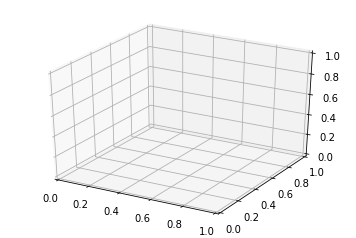

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot()

#### Indexing the single particle functions

As we use a single index to determine which SPF we wish to use when computing the matrix elements $H$ and $u$ we need to relabel the indices. We wish to create an index labeling function on the form $f(n, m) = p$ such that we get $\rvert\phi_{nm}\rangle = \rvert\phi_{p}\rangle$. Below we show how we can tabulate the conversion between these indices in Pandas.

In [59]:
index_table = pd.DataFrame(
    index=[(n, m) for n in range(5) for m in range(-5, 6)],
    columns=["energy", "n", "m", "p"])

# Set up the values for n and m in their respective columns
index_table.n = [i[0] for i in index_table.index]
index_table.m = [i[1] for i in index_table.index]

# Compute the energy with hbar = omega = 1
index_table.energy = list(map(lambda i: 2*i[0] + abs(i[1]) + 1, index_table.index))

# Sort the values according to energy and then m
index_table = index_table.sort_values(by=["energy", "m"])

# Insert increasing numbers for p in the sorted table
index_table.p = [i for i in range(len(index_table))]

display(index_table.head(20))

,energy,n,m,p
"(0, 0)",1,0,0,0
"(0, -1)",2,0,-1,1
"(0, 1)",2,0,1,2
"(0, -2)",3,0,-2,3
"(1, 0)",3,1,0,4
"(0, 2)",3,0,2,5
"(0, -3)",4,0,-3,6
"(1, -1)",4,1,-1,7
"(1, 1)",4,1,1,8
"(0, 3)",4,0,3,9


In [78]:
n = index_table.loc[index_table.p == 2].n
m = index_table.loc[index_table.p == 2].m